In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

In [3]:
def getFilters(r,width,height):
    w_ =width/2
    h_ = height/2
    x=np.linspace(-w_, w_-1,width)
    y = np.linspace(-h_, h_-1,height)
    [x,y] = np.meshgrid(x,y)
    z = np.sqrt(x**2+y**2)
    cL = z < r
    cH = ~cL
    return (cL, cH)

In [4]:
def getContrast(img):
    #green = imgsrc[:,:,1]
    #gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    norm_image = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    #histr = cv2.calcHist([gray_image],[0],None,[1],[0,1])
    return norm_image.std()

1


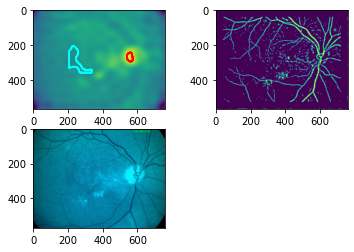

2


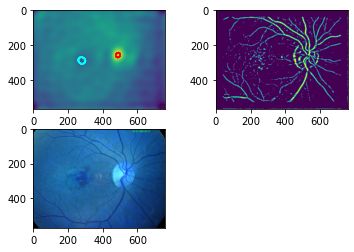

3


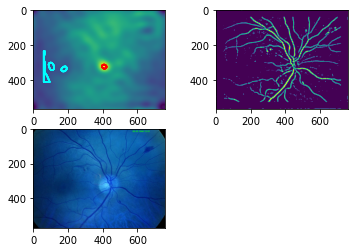

4


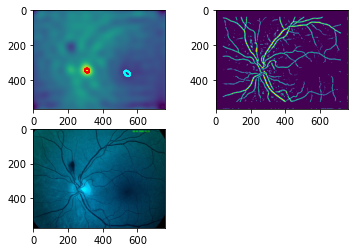

5


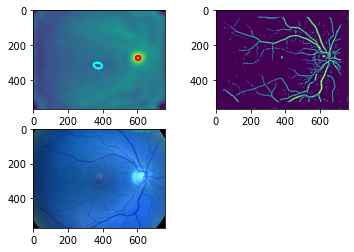

6


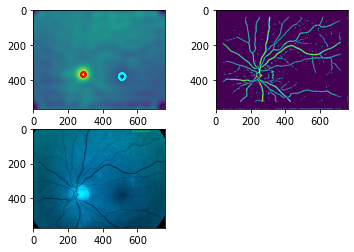

7


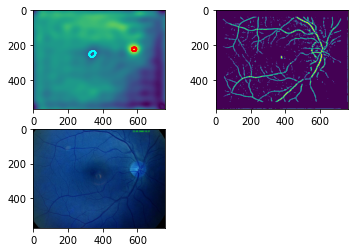

8


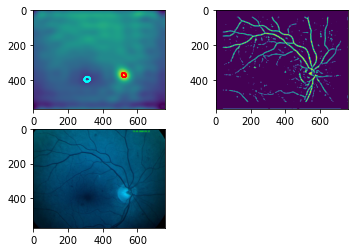

9


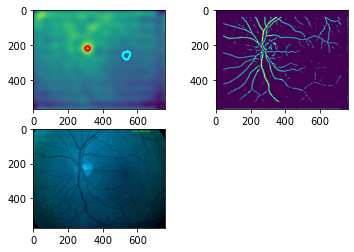

10


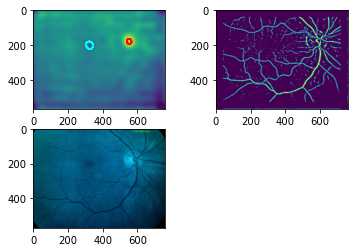

11


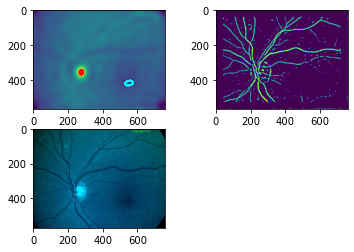

12


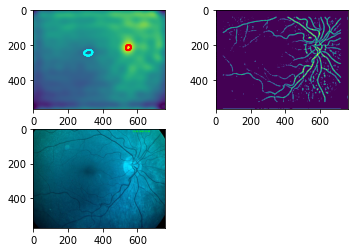

13


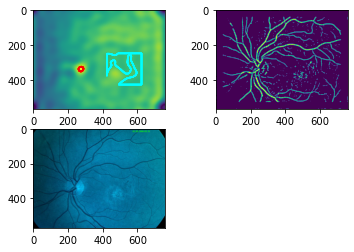

14


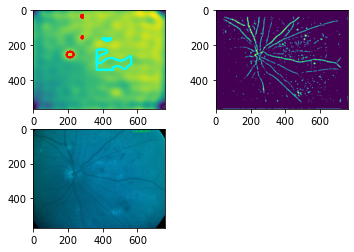

15


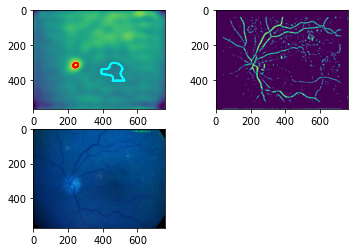

16


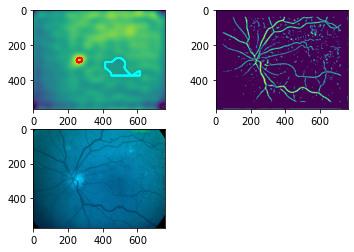

17


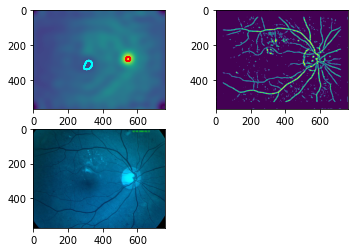

18


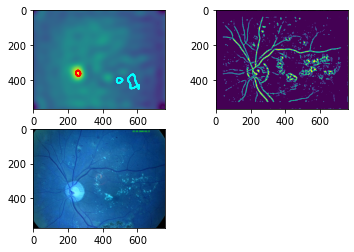

19


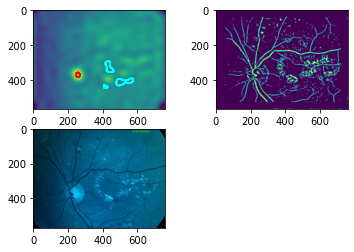

20


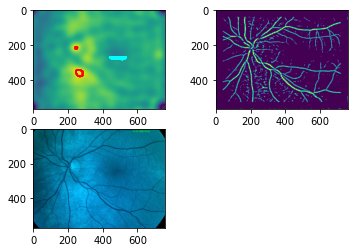

21


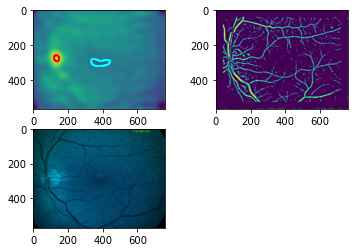

22


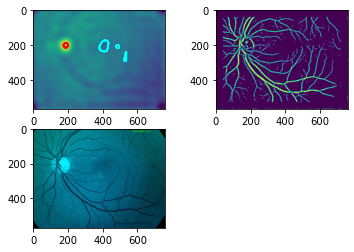

23


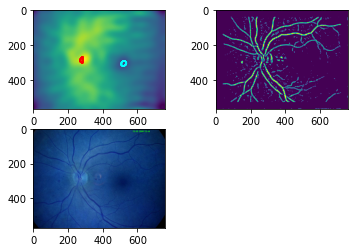

24


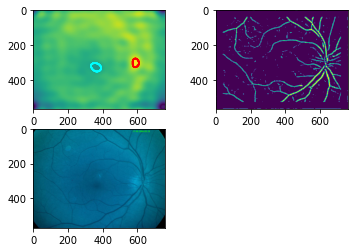

25


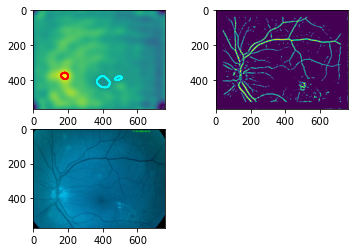

26


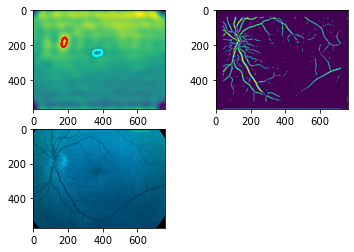

27


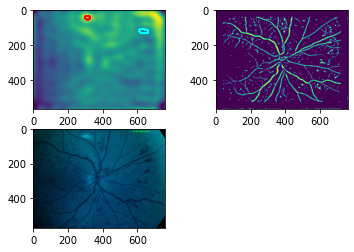

28


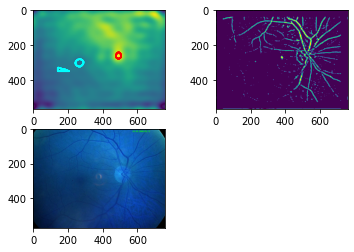

29


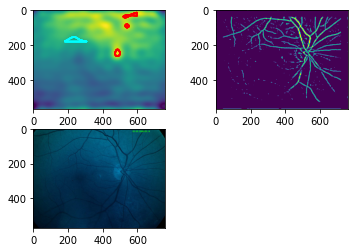

30


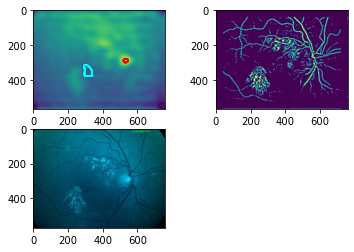

31


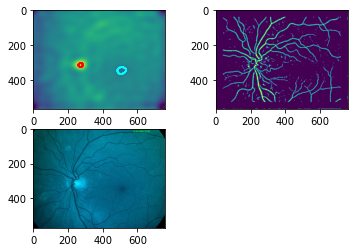

32


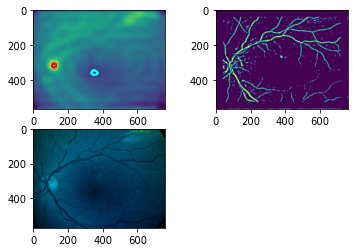

33


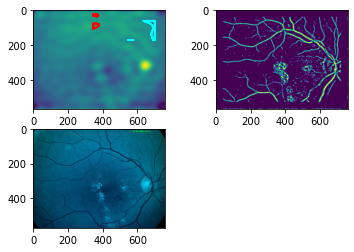

34


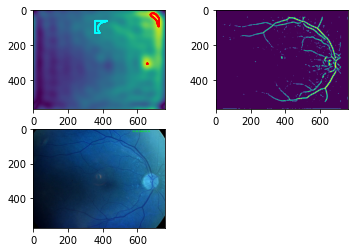

35


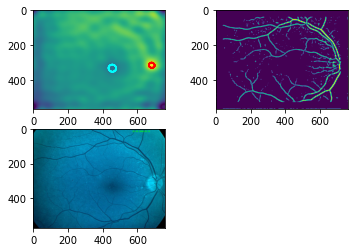

36


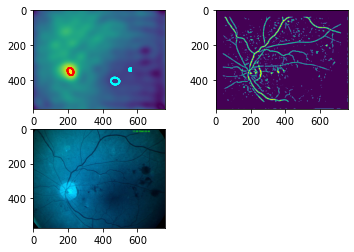

37


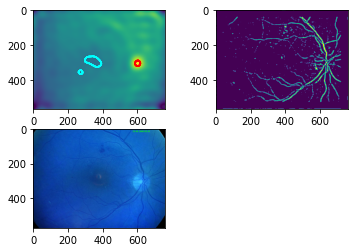

38


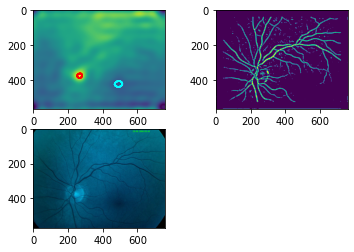

39


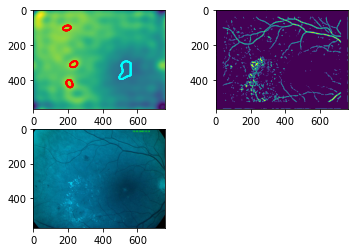

40


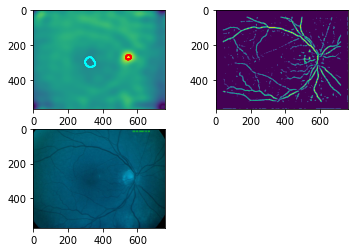

41


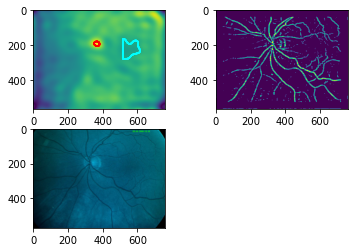

42


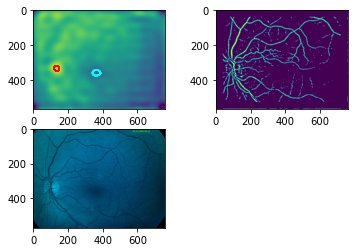

43


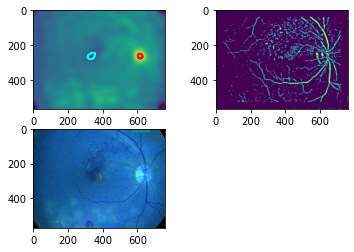

44


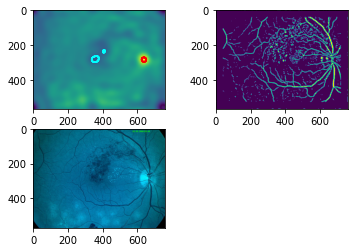

45


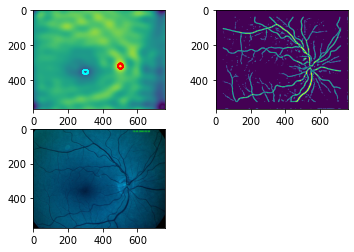

46


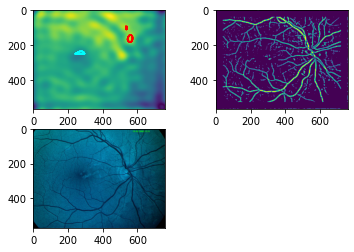

47


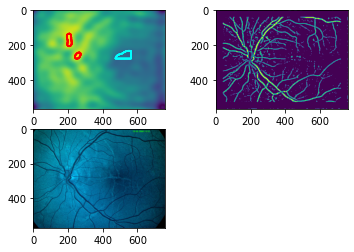

48


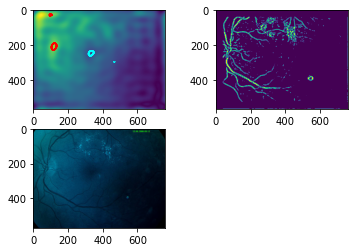

49


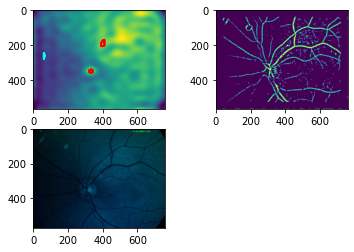

50


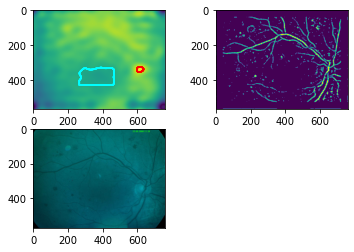

51


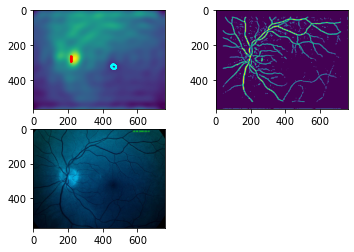

52


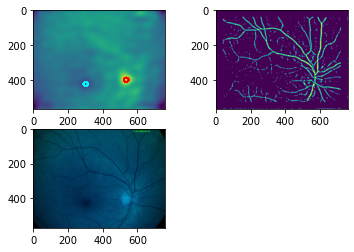

53


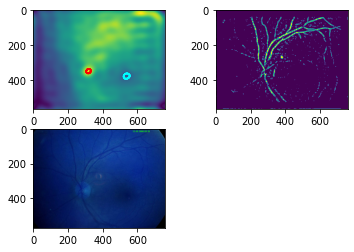

54


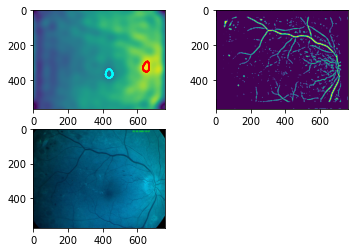

55


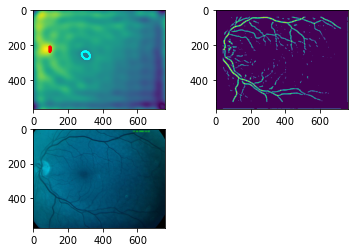

56


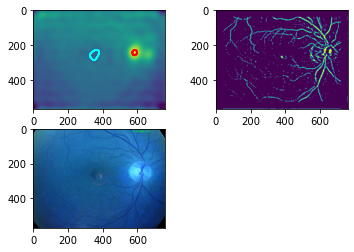

57


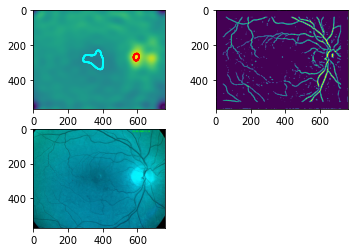

58


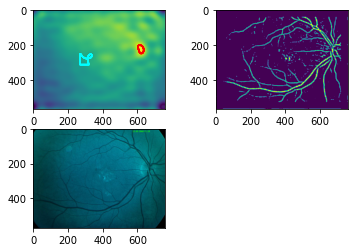

59


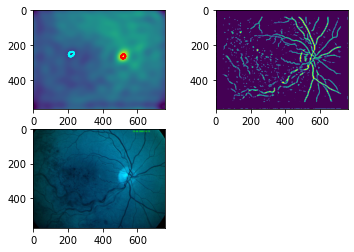

60


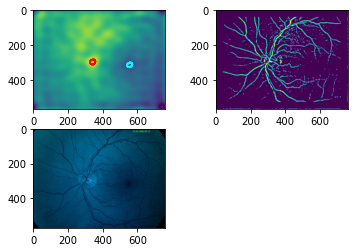

61


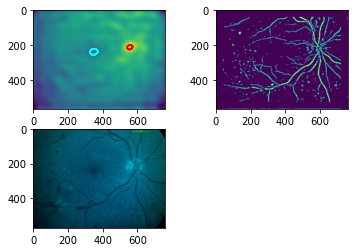

62


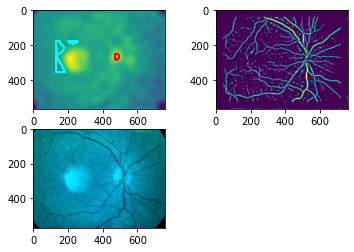

63


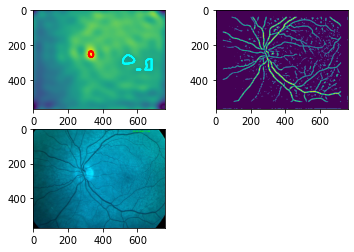

64


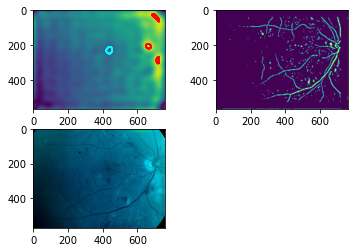

65


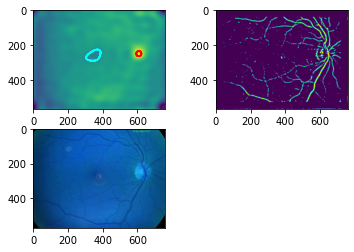

66


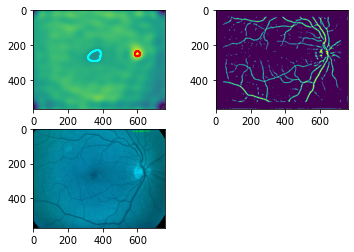

67


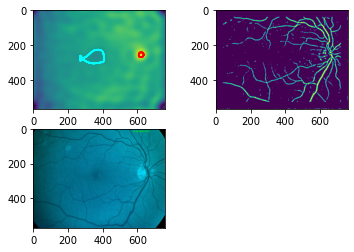

68


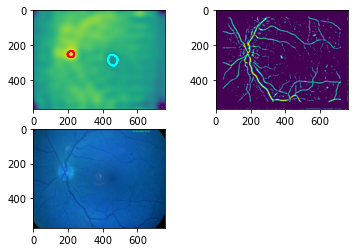

69


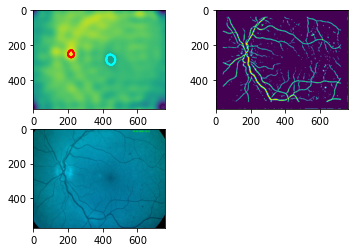

70


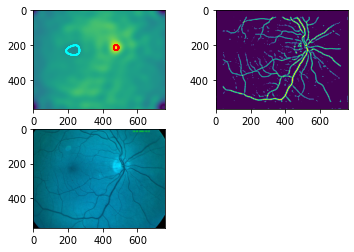

71


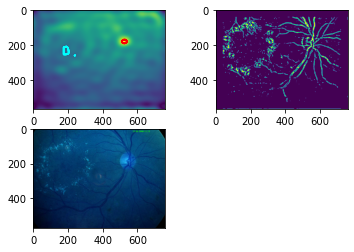

72


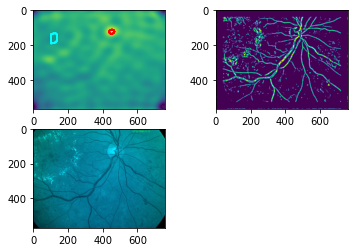

73


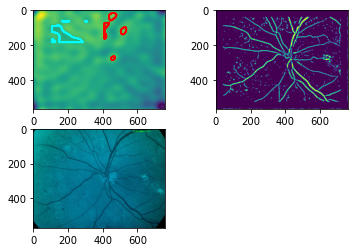

74


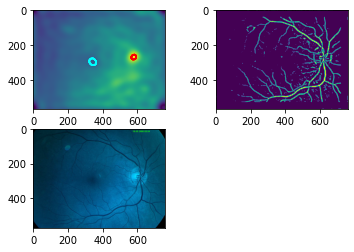

75


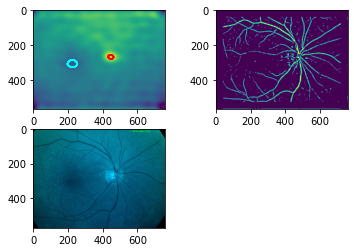

76


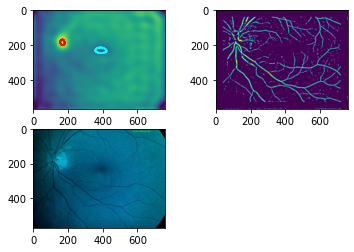

77


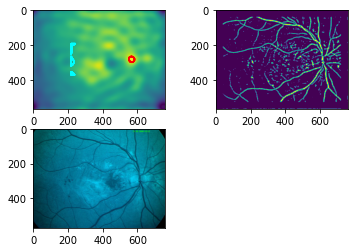

78


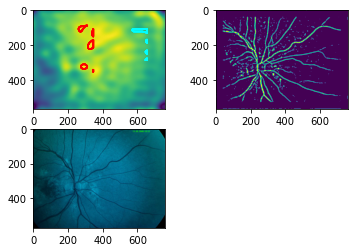

79


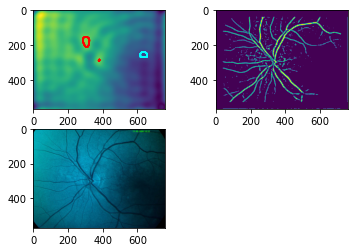

80


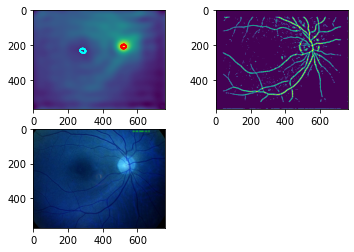

81


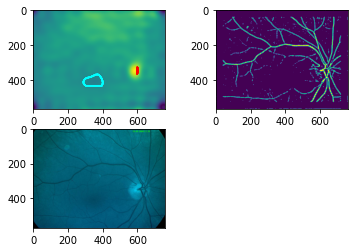

82


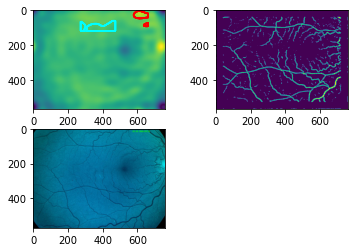

83


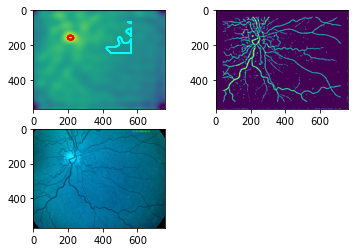

84


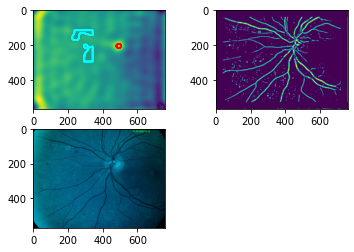

85


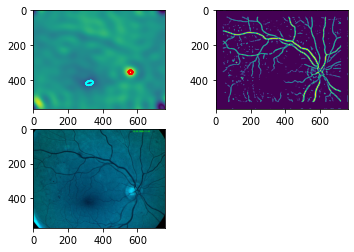

86


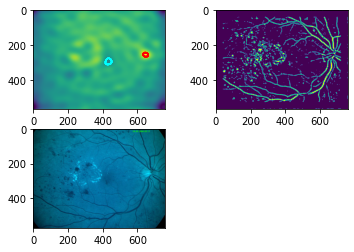

87


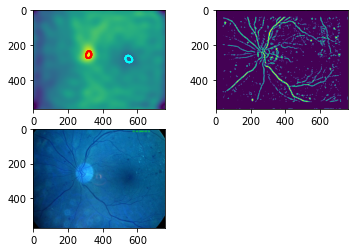

88


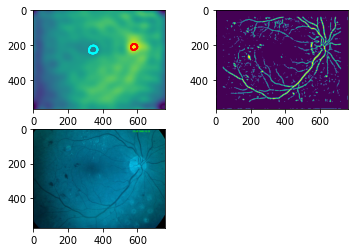

89


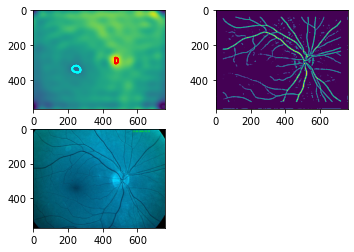

90


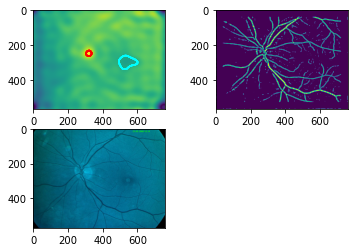

91


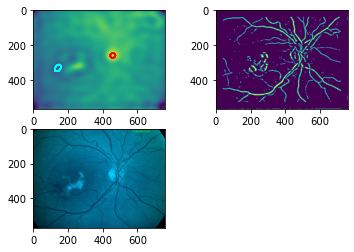

92


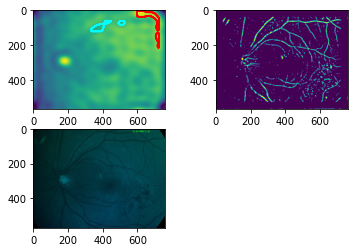

93


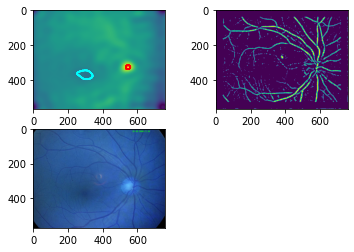

94


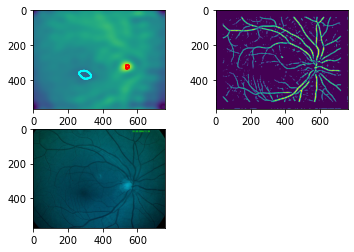

95


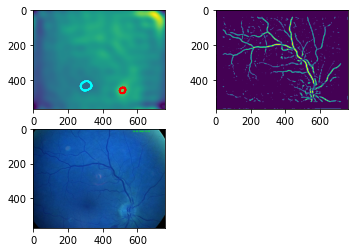

96


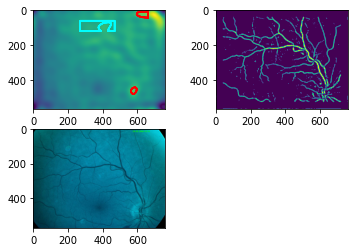

97


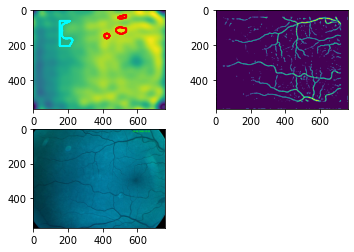

98


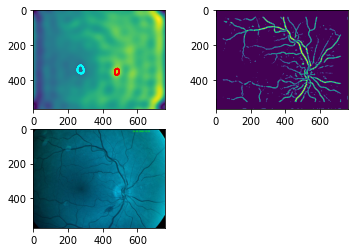

99


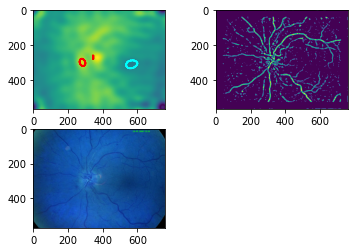

100


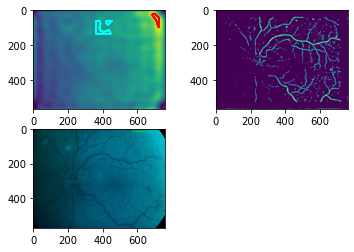

101


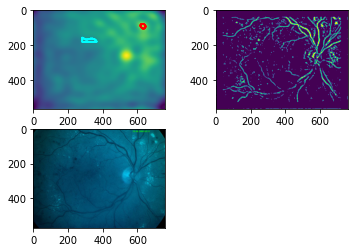

102


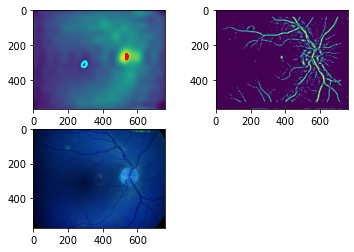

103


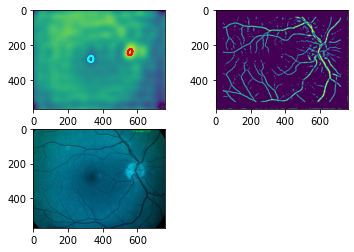

104


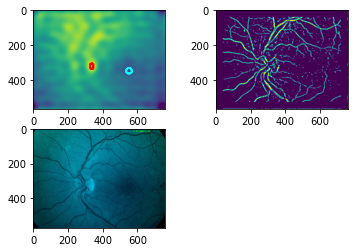

105


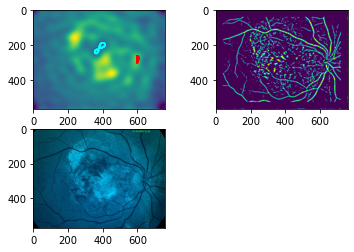

106


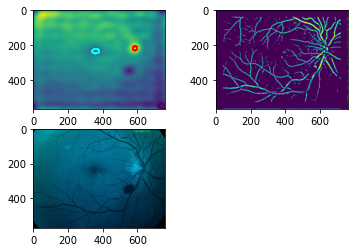

107


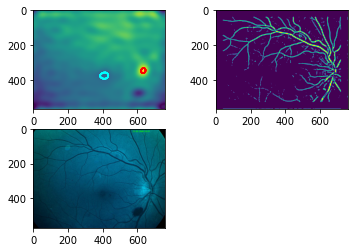

108


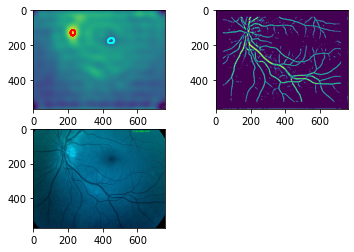

109


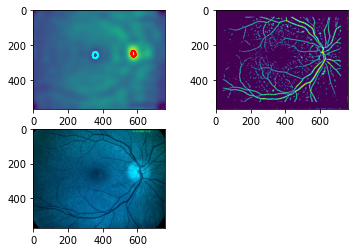

110


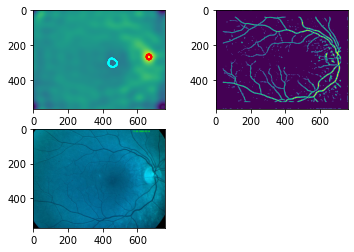

111


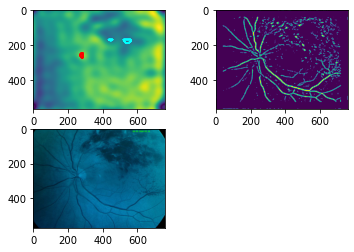

112


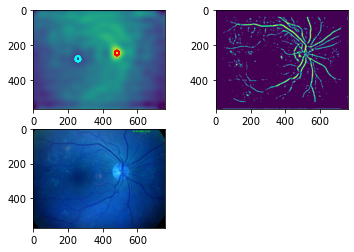

113


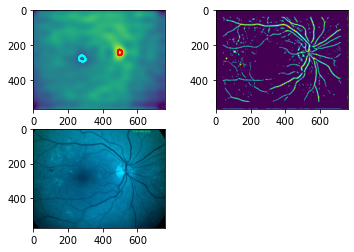

114


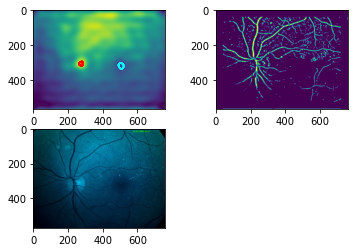

115


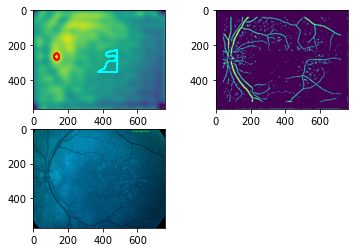

116


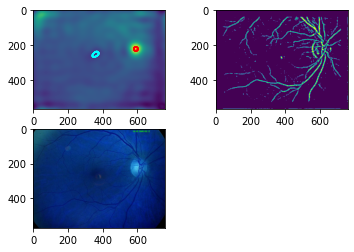

117


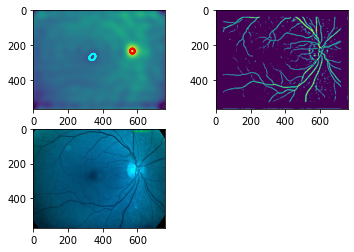

118


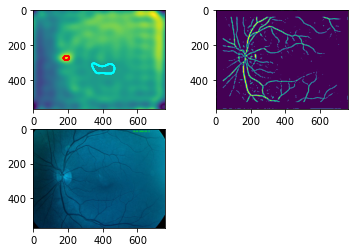

119


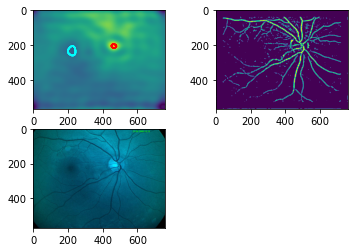

120


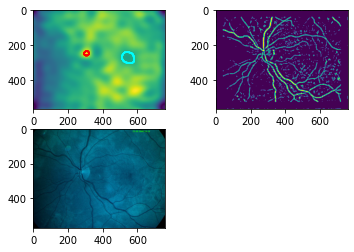

121


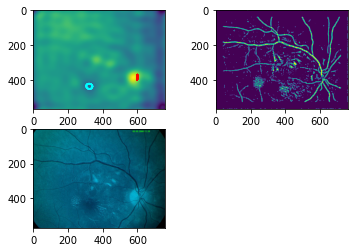

122


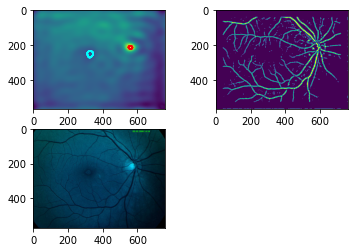

123


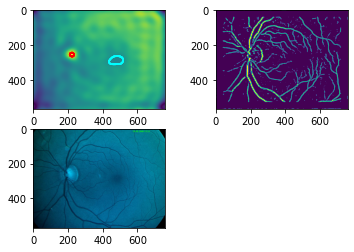

124


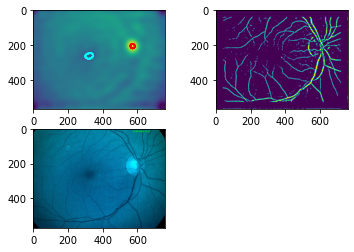

In [382]:
for i in range(1,125):
    print(i)
    inicio = time.time()
    imgsrc = cv2.imread("DRIMDB/Good/drimdb_good ({}).jpg".format(i))
    img = imgsrc[:,:,1]
    ##Application of filters
    height, width =np.shape(img)
    ft = np.fft.fftshift(np.fft.fft2(img))
    #filters on low Pass filter
    [cL, cH] = getFilters(10,width,height)
    l_ft = ft * cL 
    #filters on Band pass
    [cL1, cH1] = getFilters(20,width,height)
    [cL2, cH2] = getFilters(150,width,height)
    cBP = cH1 * cL2
    cBP = cBP.astype(float)
    cBP = cv2.GaussianBlur(cBP, ksize=(0,0),sigmaX=3,borderType=cv2.BORDER_REPLICATE)    
    h_ft = ft * cBP
    ###### Reconstruction of image #######
    low_filtered_image = np.fft.ifft2(np.fft.ifftshift(l_ft))
    high_filtered_image = np.fft.ifft2(np.fft.ifftshift(h_ft))
    
    low_f = abs(abs(low_filtered_image))
    high_f = abs(abs(low_filtered_image))
    
    ## Busqueda del disco óptico
    D1 = 40
    endx = np.shape(A)[1]-1
    endy = np.shape(A)[0]-1
    A= np.zeros(np.shape(img))
    std_high = np.std(np.reshape(np.real(high_filtered_image),width*height))    
    A[np.where(-np.real(high_filtered_image)>std_high)] = 1
    A[1:D1, :] = 0
    A[:, 1:D1] = 0
    
    A[:,endx-D1:endx] = 0
    A[endy-D1:endy,:] = 0
    suma_hp = np.sum(A)   
    ### sumatoria vertical para la busqueda del disco optico
    num  = 12
    C = np.zeros([num,1])
    nx = np.floor(height/num).astype(int)
    ny = np.floor(width/num).astype(int)
    
    for col in range(0,num):
        C[col] = np.sum(A[50:endx-50, col* ny+1: (col+1)*ny])
        
    x = np.arange(0, num,1)*nx+nx/2
    y = np.arange(0, num,1)*ny+ny/2
    ##posicion disco    
    b =np.where(C == np.amax(C))[0]
    
    ## Busqueda del maximo en low pass
    img_disco = np.zeros(np.shape(img))
    ind_disco= np.arange(round(y[max(b[0]-1,1)]),round(y[min(b[0]+1,12)]),1)
    
    thr_disco = 0.95*np.max(low_f[D1:endy-D1,ind_disco])
    img_disco[:,ind_disco] = low_f[:,ind_disco] >thr_disco
    ## Busqueda de la posicion del disco
    ind = np.where(img_disco == 1)
    
    indx_disco = ind[1]
    indy_disco = ind[0]
    
    pos_discox = np.floor(np.median(indx_disco))
    pos_discoy = np.floor(np.median(indy_disco))    
    ## 
    img_macula = np.zeros(np.shape(img))
    D=60
    ind = np.arange(max(pos_discoy-90, D),min(pos_discoy+90,np.shape(img)[0]-D),1).astype(int)
    
    if(pos_discox > np.shape(img)[1]/2):
        ind_x = np.arange(max(pos_discox-350,D),min(pos_discox-150,np.shape(img)[1]-D),1).astype(int)
    else:
        ind_x = np.arange(max(pos_discox+150,D),min(pos_discox+350,np.shape(img)[1]-D),1).astype(int)

    thr_macula = np.min(low_f[np.ix_(ind,ind_x)])*1.1
    img_macula[np.ix_(ind,ind_x)] = low_f[np.ix_(ind,ind_x)]<thr_macula
    
    plt.subplot(221)    
    plt.imshow(abs(low_filtered_image))
    plt.contour(img_disco,colors="red")
    plt.contour(img_macula, colors= "cyan")
    plt.subplot(222)
    plt.imshow(abs(A))
    plt.subplot(223)
    plt.imshow(imgsrc)
    plt.show()